# Exploratory data analysis & Simple Classifiers
## Date created: 1 March 2021
### Quick exploration of datasets considered for thesis research.
### Currently contains analyses of: Blog Authorship Corpus

In [1]:
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from langdetect import detect, detect_langs # for language detection
from tqdm.notebook import tqdm, trange
import time
import math

In [2]:
# TODO: write specification scheme for type of "simple" classifier to build and test?
# Maybe just have the notebook build, train, and test all simple ones, i.e., Logit+ n-grams, Logit + grams + linguistic features, etc.
# Specifiy trian-test splits
# What else? --> Label to predict (e.g., age cat, age number, gender, astrological sign, topic)
SEED = 420
MAX_N_GRAM = 2
TEST_SPLIT = 0.2

seeds = [1, 2, 3]
n_grams = [1, 2, 3, 4]
perc_df = 0.0020

# Read and load dataset
data = pd.read_csv("../data/blogs_kaggle/blogtext.csv")

# sub_sample = math.ceil(perc_df * data.shape[0])
#shuffle data set before subsampling
data = data.sample(frac=1).reset_index(drop=True)
sub_sample = 10000
data = data[:sub_sample]

## Exploratory analysis

In [3]:
data.describe(include = ['object', 'bool'])

,gender,topic,sign,date,text
count,10000,10000,10000,10000,10000
unique,2,40,12,922,9916
top,male,indUnk,Cancer,"02,August,2004",urlLink
freq,5054,3668,968,259,10


In [4]:
# Convert all columnsns.histplot(data, x = "age", binwidth = 3, stat = "probability")
plt.title("Unconditional Age Distribution")s (except ID and date) to object type
data['age'] = data['age'].astype(object)

Text(0.5, 1.0, 'Unconditional Age Distribution')

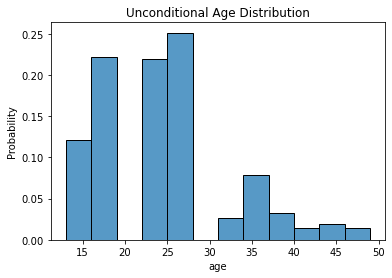

In [5]:
# Age distribution, unconditional
sns.histplot(data, x = "age", binwidth = 3, stat = "probability")
plt.title("Unconditional Age Distribution")

In [6]:
set(data['topic'])

{'Accounting',
 'Advertising',
 'Agriculture',
 'Architecture',
 'Arts',
 'Automotive',
 'Banking',
 'Biotech',
 'BusinessServices',
 'Chemicals',
 'Communications-Media',
 'Construction',
 'Consulting',
 'Education',
 'Engineering',
 'Environment',
 'Fashion',
 'Government',
 'HumanResources',
 'Internet',
 'InvestmentBanking',
 'Law',
 'LawEnforcement-Security',
 'Manufacturing',
 'Maritime',
 'Marketing',
 'Military',
 'Museums-Libraries',
 'Non-Profit',
 'Publishing',
 'RealEstate',
 'Religion',
 'Science',
 'Sports-Recreation',
 'Student',
 'Technology',
 'Telecommunications',
 'Tourism',
 'Transportation',
 'indUnk'}

In [7]:
# data.groupby(data.topic).nunique()
data.topic.value_counts()

indUnk                     3668
Student                    2237
Technology                  617
Education                   462
Arts                        450
Communications-Media        290
Internet                    252
Non-Profit                  242
Engineering                 175
Publishing                  123
Law                         123
Government                  120
Science                     111
Consulting                   82
Religion                     75
Fashion                      73
Telecommunications           69
Advertising                  69
Marketing                    68
Banking                      63
Chemicals                    59
BusinessServices             58
Accounting                   53
Sports-Recreation            46
HumanResources               45
Biotech                      41
Museums-Libraries            40
Military                     36
Manufacturing                32
RealEstate                   32
Tourism                      29
LawEnfor

Text(0.5, 1.0, 'Unconditional Topic Distribution')

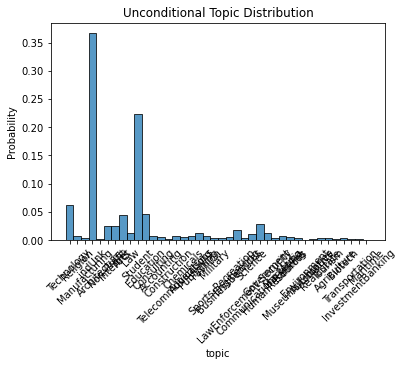

In [8]:
sns.histplot(data, x = "topic", binwidth = 3, stat = "probability")
plt.xticks(rotation=45)
plt.title("Unconditional Topic Distribution")

Text(0.5, 1.0, 'Age Distribution, Conditioned On Gender')

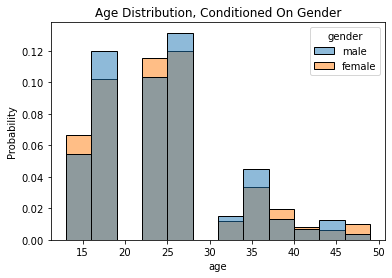

In [9]:
# Age distribution, conditioned on gender
sns.histplot(data, x = "age", hue = "gender", binwidth = 3, stat = "probability")
plt.title("Age Distribution, Conditioned On Gender")

In [10]:
# sns.histplot(data, x = 'sign', stat = 'probability')
# plt.xticks(rotation=45)
# plt.title("Distribution of Astrological Signs")

In [11]:
# sns.histplot(data, x = 'topic', stat = 'probability')
# plt.xticks(rotation=85)
# plt.title("Distribution of Topics")

Text(0.5, 1.0, 'Age Distribution, Conditioned On Topic')

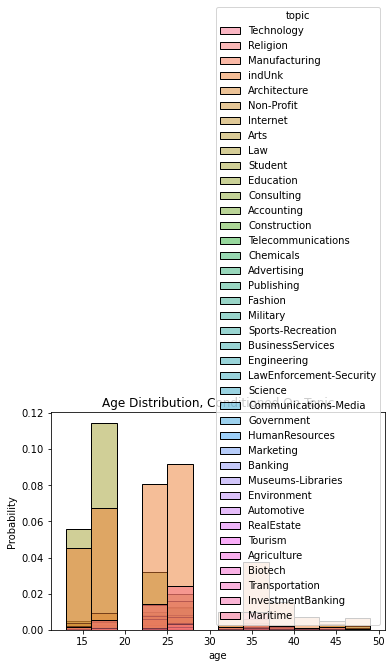

In [12]:
# Age distribution, conditioned on gender
sns.histplot(data, x = "age", hue = "topic", binwidth = 3, stat = "probability")
plt.title("Age Distribution, Conditioned On Topic")

# Examples for Human(e) AI plenary meeting

In [13]:
# data_1317 = data[data['age'] < 18]
# data_1317.reset_index(drop = True, inplace = True)
# data_1317.head()

In [14]:
# data_1317.shape

In [15]:
# data_1317.text[666]

In [16]:
# data_3347 = data[data['age'] > 32]
# data_3347.reset_index(drop = True, inplace = True)
# data_3347.shape

In [17]:
# data_3347.text[2000]

## Data cleaning / preprocessing

In [18]:
# Removing all unwanted text/characters from data['text'] column

# Remove all non-alphabetical characters
data['clean_data'] = data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ', x))

In [19]:
# Make all letters lower case
data['clean_data'] = data['clean_data'].apply(lambda x: x.lower())

In [20]:
# Remove white space from beginning and end of string
data['clean_data'] = data['clean_data'].apply(lambda x: x.strip())

In [21]:
# Remove instances empty strings
before_rm_empty = len(data)
data.drop(data[data.clean_data == ''].index, inplace = True)

print(f'{before_rm_empty - len(data)} instances removed.')

67 instances removed.


In [22]:
# Remove texts that are probably not English by filtering blogs that dont contain at least one of the top 50 most used English words

# create dict with most common English words
top_en_words = {}
with open('../data/wordlists/top1000english.txt') as f:
    count = 1
    for line in f:
        key = line.split()[0].lower()
        top_en_words[key] = count
        count += 1
        
        # Stop at top 50 words. Idea taken from DialoGPT paper.
        if count > 50:
            break


data['top_50_en'] = data['clean_data'].apply(lambda x : True if not set(x.split()).isdisjoint(top_en_words) else False)

def top_lang_detect(text):
    
    detected_langs = detect_langs(text)
    
    return detected_langs[0].lang
        

def top_prob_detect(text):
    
    detected_langs = detect_langs(text)
    
    return detected_langs[0].prob

start_time = time.time()
data['top_lang'] = data['clean_data'].apply(top_lang_detect)
print(f"Top lang detection took {time.time() - start_time} seconds")
start_time = time.time()
data['top_prob'] = data['clean_data'].apply(top_prob_detect)
print(f"Top lang prob lang detection took {time.time() - start_time} seconds")

Top lang detection took 109.12626194953918 seconds
Top lang prob lang detection took 100.33755493164062 seconds


In [23]:
# Remove rows without one of top50 most common english words
before_top50_removal = len(data)
data.drop(data[data['top_50_en'] == False].index, inplace = True)
print(f"{before_top50_removal - len(data)} instances dropped")

353 instances dropped


In [24]:
before_top_lang = len(data)
data.drop(data[data['top_lang'] != 'en'].index, inplace = True)
print(f'{before_top_lang - len(data)} instances dropped.')

192 instances dropped.


In [25]:
before_top_prob = len(data)
data.drop(data[data['top_prob'] < 0.9].index, inplace = True)
print(f'{before_top_prob - len(data)} instances dropped.')

185 instances dropped.


In [26]:
# Remove stop words
stopwords = set(nltk.corpus.stopwords.words('english')) # use set (hash table) data structure for faster lookup

# also add urllink and nbsp to set of words to remove
stopwords.update(['urllink', 'nbsp'])

data['clean_data'] = data['clean_data'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

In [27]:
# Check difference: before
print(f"Unprocessed data =====> {data['text'][0]}")
print(81 * "=")
# After
print(f"Cleaned data so far =====> {data['clean_data'][0]}")

Unprocessed data =====>                   Passion with CW  Wow, we just came back from seeing The Passion, with my friend CW, who I have written about before, and his wife.  Intense.  Here are a few things that struck me about the movie: - Malchus, the soldier who got his ear cut off, and whom Jesus healed.  What a reaction he had to Jesus.  No more being a soldier for him. - The way Jesus looks at people. - The scene when Mary runs to pick him up after he falls down with the cross, one of the many times, and the flashback to when he was just a little boy.  Heart wrenching. - Simon from Cyrene, who helps him carry the cross all that way.  Did you notice the way he really helped, like there was something significant about it. - The details of all the blood dripping down the crosses.  I had never visualized it like that before.  But it sure must have been bloody. - Two Roman soldiers who stuck around at the end to help get Jesus' body down. Needless to say, I was impacted.  I won't ever 

In [28]:
# Drop columns that are uninformative for writing style (i.e., ID and date)
data.drop(['id', 'date'], axis = 1, inplace = True)

In [29]:
# Add labels for age categories
def age_to_cat(age):
    '''Returns age category label for given age number.'''
    
    if 13 <= int(age) <= 17:
        return '13-17'
    elif 23 <= int(age) <= 27:
        return '23-27'
    elif 33 <= int(age):
        return '33-47'
    else:
        print(int(age))
        raise ValueError("Given age not in one of pre-defined age groups.")


data['age_cat'] = data['age'].apply(age_to_cat)

In [44]:
def topic_to_cat(topic):
    
    if topic == 'indUnk':
        return 'unknown'
    elif topic == 'Student':
        return 'student'
    elif topic == "Technology":
        return 'technology'
    elif topic == 'Education':
        return 'education'
    elif topic == 'Arts':
        return 'arts'
    else:
        return 'other'

data['topic_cat'] = data['topic'].apply(topic_to_cat)

Text(33.0, 0.5, 'Age group')

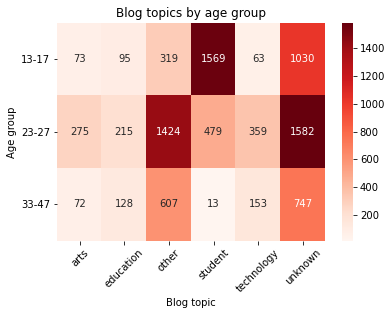

In [54]:
sns.heatmap(pd.crosstab(data.age_cat, data.topic_cat), annot=True, fmt='g', cmap = 'Reds')
plt.xticks(rotation=45)
plt.yticks(rotation = 0)
plt.title("Blog topics by age group")
plt.xlabel("Blog topic")
plt.ylabel("Age group")

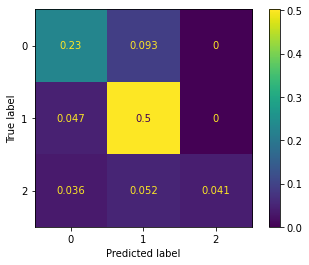

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array([[0.22797927, 0.09326425, 0.], [0.04663212, 0.50259067, 0.],[0.03626943, 0.05181347, 0.04145078]])
ConfusionMatrixDisplay(cm).plot()

In [39]:
# Merge all possibly interesting labels into one column
data['labels'] = data.apply(lambda col: [col['gender'], str(col['age']), col['topic'], col['sign']], axis = 1)

# Only keep age as label
# data['labels'] = data.apply(lambda col: [str(col['age'])], axis = 1) # TODO: Why keep age as string?
# data['labels'] = data.apply(lambda col: [col['age']], axis = 1)
data['labels'] = data.apply(lambda col: [col['age_cat']], axis = 1)

In [40]:
# Reduce dataframe to only contain cleaned blogs and list of labels
data = data[['clean_data', 'labels']]


In [30]:
# save pre-processed dataframe to csv
# data.to_csv("blogger_preprocessed_clean_data_labels.csv")

### Bi-gram and tri-gram models

In [32]:
# results dict
accs_all = {}
class_labels_list = ['13-17', '23-27', '33-47']

# Evaluate performance
def print_evaluation_scores(labels, preds):
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    #print(f"F1 score: {f1_score(labels, preds, average = 'micro')}")
    #print(f"Average precision: {average_precision_score(labels, preds, average = 'micro')}")
    #print(f"Average recall: {recall_score(labels, preds, average = 'micro')}")

def print_top_n(vectorizer, clf, class_labels, n_feat = 10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        topn = np.argsort(clf.estimators_[i].coef_)[0][-n_feat:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in topn)))

def most_informative_feature_for_class(vectorizer, classifier, class_labels, n=10):
    #labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        topn = sorted(zip(classifier.estimators_[i].coef_[0], feature_names))[-n:]
        
        for coef, feat in topn:
            print(class_label, feat, coef)


for seed in tqdm(seeds, desc = "Seed loop."):
    
    # set seed for reproducibility
    np.random.seed(seed)
        
    # shuffle dataframe
    data = data.sample(frac=1).reset_index(drop=True)
    
    
    for n in tqdm(n_grams, desc = "n gram loop."):
    
        # Split data into features/ X and labels / Y 
        X = data['clean_data']
        Y = data['labels']

        # n-gram model
        vectorizer = CountVectorizer(binary = True, ngram_range = (1, n))

        # fit model
        X = vectorizer.fit_transform(X)

        # # check out a sample of the uni- and bigrams
        # print(vectorizer.get_feature_names()[:10])

        # Get label counts
        label_counts = {}

        for labels in data.labels.values:
            for label in labels:
                if label in label_counts:
                    label_counts[label] += 1
                else:
                    label_counts[label] = 1

        label_counts

        # Binarize the labels for prediction 
        binarizer = MultiLabelBinarizer(classes = sorted(label_counts.keys()))

        Y = binarizer.fit_transform(data.labels)

        label_counts.keys()

        # Split data into train and test sets
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SPLIT)

        # Fit logistic regression model
        start_time = time.time()
        model = LogisticRegression(solver = 'lbfgs', multi_class='ovr', max_iter = 1000000)
        model = OneVsRestClassifier(model)
#         model = MultiOutputClassifier(model)
        model.fit(X_train, Y_train)
        print(f"Fitting model took {time.time() - start_time} seconds.")

        # make predictions on test set
        Y_pred = model.predict(X_test)

        Y_pred_inversed = binarizer.inverse_transform(Y_pred)
        Y_test_inversed = binarizer.inverse_transform(Y_test)
        
        print("=" * 81)

        print(f"n = {n}")
        print_evaluation_scores(Y_test, Y_pred)
        
        if n in accs_all:
            accs_all[n].append(accuracy_score(Y_test, Y_pred))
        else:
            accs_all[n] = [accuracy_score(Y_test, Y_pred)]
        
        # Print most informative features
        print("Most informative features per age-group.")
        print_top_n(vectorizer = vectorizer, clf = model, class_labels = class_labels_list, n_feat = 20)
        
        print("-" * 81)
#         print("Some failure cases.")
# #         predictions = model.predict(inputs)
#         for i, (x, pred, label) in enumerate(zip(X_test, Y_pred, Y_test)):
#             if (pred != label).any():
#                 print(f"pred: {pred}")
#                 print(f"label: {label}")
#                 pred_cat = binarizer.classes_[np.where(pred == 1)[0][0]]
#                 label_cat = binarizer.classes_[np.where(label == 1)[0][0]]
#                 print(data['clean_data'][i], 'has been classified as ', pred_cat, 'and should be ', label_cat)
        
        print("=" * 81)
        
#         most_informative_feature_for_class(vectorizer = vectorizer, classifier = model, class_labels = class_labels_list, n=10)

Seed loop.:   0%|          | 0/3 [00:00<?, ?it/s]

n gram loop.:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting model took 1240.5078852176666 seconds.
n = 1
Accuracy: 0.6057505803046201
Most informative features per age-group.
13-17: smutty jammi betso jesser hmmn nicki kuronue kairsie linds idk runescape marten feanor roskilly bigsmut tmk arv ceff exun xbubzx
23-27: andrei ellmistress mokalus steelez deane jonnie kristyn jerel cyodfs soulsag fonz hakx sanda carolynn xrating damo killy mungo daf baity
33-47: quotejill maiko guam katelyn giulio vicente oef nongirlfriend shella heff katya pandyland shep evermean oif vlh jpservicez corsair spanners duf
---------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# print("OvR")
# accs_all_ovr

In [ ]:
# print("MO")
# accs_all_mo

# Plot results

In [ ]:
def plot_accuracies(accs):
    
    means = [np.mean(accs[n]) for n in range(1, len(accs) + 1)]
    print(np.mean(means))
    stds = [np.std(accs[n]) for n in range(1, len(accs) + 1)]
    
    x_pos = np.arange(len(accs))
    x_labels = list(accs.keys())
    
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean classification accuracy.')
    ax.set_xlabel("$n$")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    ax.set_title('Age group prediction accuracy for various n-gram models.')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

In [ ]:
plot_accuracies(accs_all)